In [53]:
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import re
# Deep Learning
# Import library tambahan untuk deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GRU, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


from wordcloud import WordCloud
import matplotlib.pyplot as plt


from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory



# NLTK
import nltk  # <-- penting!
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("Semua library berhasil diimport!")


Semua library berhasil diimport!


In [54]:
import pandas as pd

# =====================================================
# 1. PERSIAPAN DATA
# =====================================================

def load_datasets():
    """Fungsi untuk memuat dataset utama dan lexicon"""
    try:
        # Muat dataset utama
        df_main = pd.read_excel('ABSA_db.xlsx')  # Perbaikan: read_excel, bukan readexcel
        print(f"✅ Dataset utama berhasil dimuat: {df_main.shape}")
        print(f"Kolom: {list(df_main.columns)}")
        
        # Muat lexicon positif dan negatif
        df_positive = pd.read_csv('positive.csv')
        df_negative = pd.read_csv('negative.csv')
        
        print(f"✅ Lexicon positif: {df_positive.shape[0]} kata")
        print(f"✅ Lexicon negatif: {df_negative.shape[0]} kata")
        
        return df_main, df_positive, df_negative
        
    except FileNotFoundError as e:
        print(f"❌ File tidak ditemukan: {e}")
        print("⚠️ Membuat dataset dummy untuk demonstrasi...")
        return create_dummy_datasets()

def create_dummy_datasets():
    """Membuat dataset dummy untuk demonstrasi"""
    dummy_data = {
        'no': range(1, 501),
        'nama': [f'User_{i}' for i in range(1, 501)],
        'kalimat': [
            'Guru di pesantren ini sangat baik dan sabar dalam mengajar',
            'Fasilitas pesantren kurang memadai dan perlu perbaikan',
            'Lingkungan pesantren sangat nyaman untuk belajar',
            'Kegiatan di pesantren sangat beragam dan menarik',
            'Pembinaan karakter di pesantren sangat baik',
            'Prestasi santri di pesantren ini membanggakan',
            'Akademik di pesantren perlu ditingkatkan lagi',
            'Motivasi spiritual yang diberikan sangat menginspirasi',
            'Sosial antar santri sangat harmonis dan rukun',
            'Secara umum pesantren ini sudah cukup baik'
        ] * 50,
        'tema_postingan': [
            'pendidikan', 'fasilitas', 'lingkungan', 'kegiatan', 'karakter',
            'prestasi', 'akademik', 'spiritual', 'sosial', 'umum'
        ] * 50,
        'ponpes': [f'Ponpes_{i % 5 + 1}' for i in range(500)],
        'aspek_manual': [''] * 500
    }
    
    df_main = pd.DataFrame(dummy_data)
    
    # Lexicon dummy
    positive_words = ['baik', 'bagus', 'senang', 'puas', 'nyaman', 'hebat', 'sukses', 'indah', 'harmonis', 'menginspirasi']
    negative_words = ['buruk', 'jelek', 'sedih', 'kecewa', 'tidak nyaman', 'gagal', 'rusak', 'kotor', 'konflik', 'mengecewakan']
    
    df_positive = pd.DataFrame({
        'kata': positive_words,
        'bobot': [1] * len(positive_words)
    })
    
    df_negative = pd.DataFrame({
        'kata': negative_words,
        'bobot': [-1] * len(negative_words)
    })
    
    print("✅ Dataset dummy berhasil dibuat!")
    return df_main, df_positive, df_negative

# Load datasets
df_main, df_positive, df_negative = load_datasets()


✅ Dataset utama berhasil dimuat: (808, 6)
Kolom: ['no', 'nama', 'kalimat', 'tema_postingan', 'ponpes', 'aspek_manual']
✅ Lexicon positif: 3609 kata
✅ Lexicon negatif: 6609 kata


=== EKSPLORASI & VISUALISASI AWAL ===


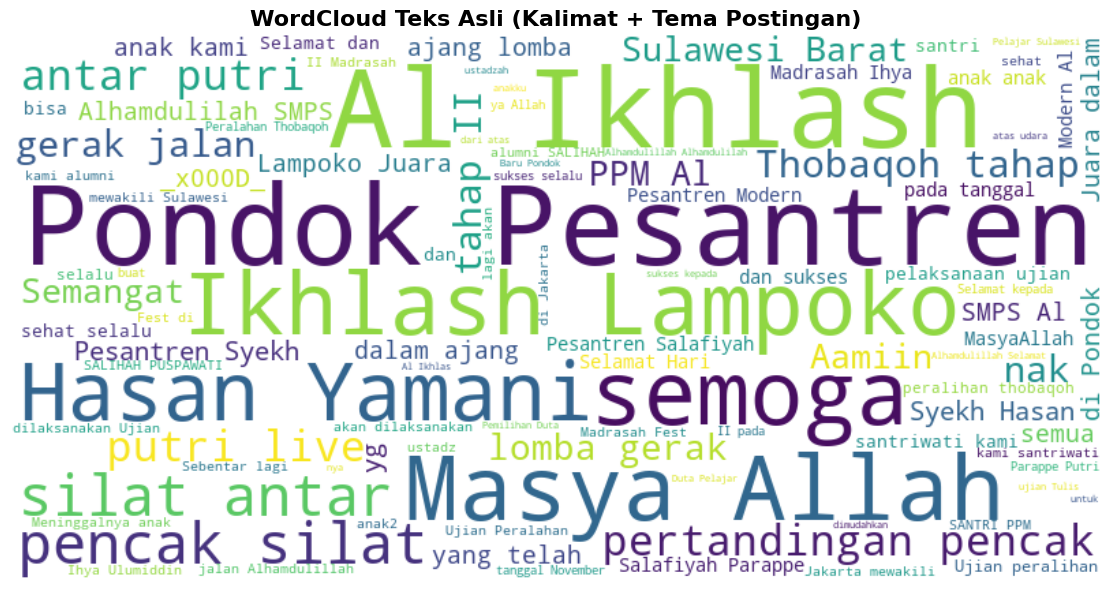

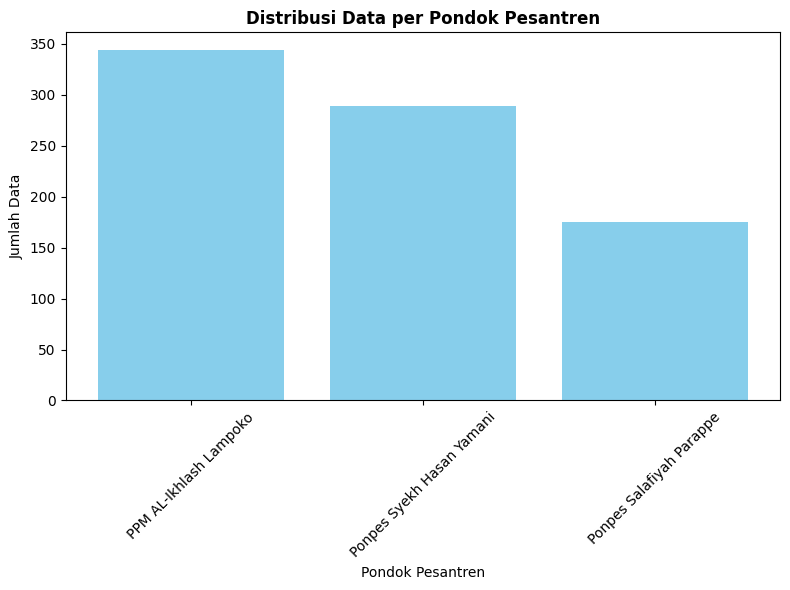

Statistik Distribusi Data:
Total data: 808
Jumlah ponpes: 3


In [55]:
# =====================================================
# 2. EKSPLORASI & VISUALISASI AWAL
# =====================================================

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud_original(df):
    """Membuat wordcloud dari teks asli"""
    # Gabungkan semua teks
    all_text = ' '.join(df['kalimat'].astype(str) + ' ' + df['tema_postingan'].astype(str))
    
    # Buat wordcloud
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         colormap='viridis',
                         max_words=100).generate(all_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud Teks Asli (Kalimat + Tema Postingan)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def analyze_distribution(df):
    """Analisis distribusi data"""
    plt.figure(figsize=(8, 6))
    
    # Distribusi per ponpes saja
    ponpes_counts = df['ponpes'].value_counts()
    plt.bar(ponpes_counts.index, ponpes_counts.values, color='skyblue')
    plt.title('Distribusi Data per Pondok Pesantren', fontweight='bold')
    plt.xlabel('Pondok Pesantren')
    plt.ylabel('Jumlah Data')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("Statistik Distribusi Data:")
    print(f"Total data: {len(df)}")
    print(f"Jumlah ponpes: {df['ponpes'].nunique()}")

# Jalankan eksplorasi awal
print("=== EKSPLORASI & VISUALISASI AWAL ===")
create_wordcloud_original(df_main)
analyze_distribution(df_main)


In [56]:
# =====================================================
# 3. PRAPROSES TEKS
# =====================================================

class TextPreprocessor:
    def __init__(self):
        # Initialize Sastrawi components
        self.stemmer_factory = StemmerFactory()
        self.stemmer = self.stemmer_factory.create_stemmer()
        
        self.stopword_factory = StopWordRemoverFactory()
        self.stopword_remover = self.stopword_factory.create_stop_word_remover()
        
        # Emoji mapping
        self.emoji_dict = {
            '😊': 'emoji_senyum',
            '😢': 'emoji_sedih',
            '😡': 'emoji_marah',
            '❤️': 'emoji_cinta',
            '👍': 'emoji_jempol',
            '👎': 'emoji_jempol_bawah',
            '😍': 'emoji_cinta_mata',
            '😭': 'emoji_menangis',
            '🤗': 'emoji_peluk',
            '🙏': 'emoji_doa'
        }
        
        # Normalization dictionary
        self.normalize_dict = {
            'gak': 'tidak',
            'ga': 'tidak',
            'nggak': 'tidak',
            'yg': 'yang',
            'dgn': 'dengan',
            'utk': 'untuk',
            'krn': 'karena',
            'jg': 'juga',
            'lg': 'lagi',
            'udh': 'sudah',
            'udah': 'sudah',
            'blm': 'belum',
            'belom': 'belum',
            'bgt': 'banget',
            'bgt': 'sangat',
            'bgt': 'sekali'
        }
    
    def clean_text(self, text):
        """Membersihkan teks dari tanda baca, angka, dan karakter khusus"""
        if pd.isna(text):
            return ""
        
        text = str(text)
        # Hapus URL
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Hapus mention dan hashtag
        text = re.sub(r'@\w+|#\w+', '', text)
        # Hapus angka
        text = re.sub(r'\d+', '', text)
        # Hapus tanda baca kecuali spasi
        text = re.sub(r'[^\w\s]', ' ', text)
        # Hapus extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def transform_emoji(self, text):
        """Transformasi emoji menjadi token deskriptif"""
        for emoji, description in self.emoji_dict.items():
            text = text.replace(emoji, f' {description} ')
        return text
    
    def case_folding(self, text):
        """Mengubah teks menjadi huruf kecil"""
        return text.lower()
    
    def normalize_text(self, text):
        """Normalisasi kata tidak baku"""
        words = text.split()
        normalized_words = [self.normalize_dict.get(word, word) for word in words]
        return ' '.join(normalized_words)
    
    def tokenize(self, text):
        """Tokenisasi kata"""
        return word_tokenize(text)
    
    def remove_stopwords(self, text):
        """Hapus stopword"""
        return self.stopword_remover.remove(text)
    
    def stem_text(self, text):
        """Stemming menggunakan Sastrawi"""
        return self.stemmer.stem(text)
    
    def preprocess(self, text):
        """Pipeline lengkap preprocessing"""
        # Step 1: Clean text
        text = self.clean_text(text)
        
        # Step 2: Transform emoji
        text = self.transform_emoji(text)
        
        # Step 3: Case folding
        text = self.case_folding(text)
        
        # Step 4: Normalize
        text = self.normalize_text(text)
        
        # Step 5: Remove stopwords
        text = self.remove_stopwords(text)
        
        # Step 6: Stemming
        text = self.stem_text(text)
        
        return text

# Initialize preprocessor
preprocessor = TextPreprocessor()


In [57]:
# =====================================================
# 4. PENGGABUNGAN FITUR TEKS
# =====================================================

def combine_text_features(df):
    """Gabungkan kalimat dan tema_postingan setelah preprocessing"""
    print("Melakukan preprocessing teks...")
    
    # Preprocess kalimat
    df['kalimat_processed'] = df['kalimat'].apply(preprocessor.preprocess)
    
    # Preprocess tema_postingan
    df['tema_processed'] = df['tema_postingan'].apply(preprocessor.preprocess)
    
    # Gabungkan kedua fitur
    df['text_combined'] = df['kalimat_processed'] + ' ' + df['tema_processed']
    
    print("Preprocessing selesai!")
    return df

# Jalankan penggabungan fitur
df_main = combine_text_features(df_main)

# Tampilkan contoh hasil preprocessing
print("\n=== CONTOH HASIL PREPROCESSING ===")
for i in range(3):
    print(f"\nData ke-{i+1}:")
    print(f"Original: {df_main.iloc[i]['kalimat']}")
    print(f"Processed: {df_main.iloc[i]['text_combined']}")


Melakukan preprocessing teks...
Preprocessing selesai!

=== CONTOH HASIL PREPROCESSING ===

Data ke-1:
Original: MasyaAllah
Processed: masyaallah santri ppm al ikhlash serah bantu korban bakar desa bonne bonne

Data ke-2:
Original: Pimpinan Pondok terkeren
Processed: pimpin pondok keren pimpin al ikhlash terima kunjung urus kks rukun keluarga sulawesi kairo

Data ke-3:
Original: Sehat selalu pak ustaz. Aamiin
Processed: sehat selalu pak ustaz aamiin pimpin al ikhlash terima kunjung urus kks rukun keluarga sulawesi kairo



=== ANALISIS FREKUENSI KATA ===


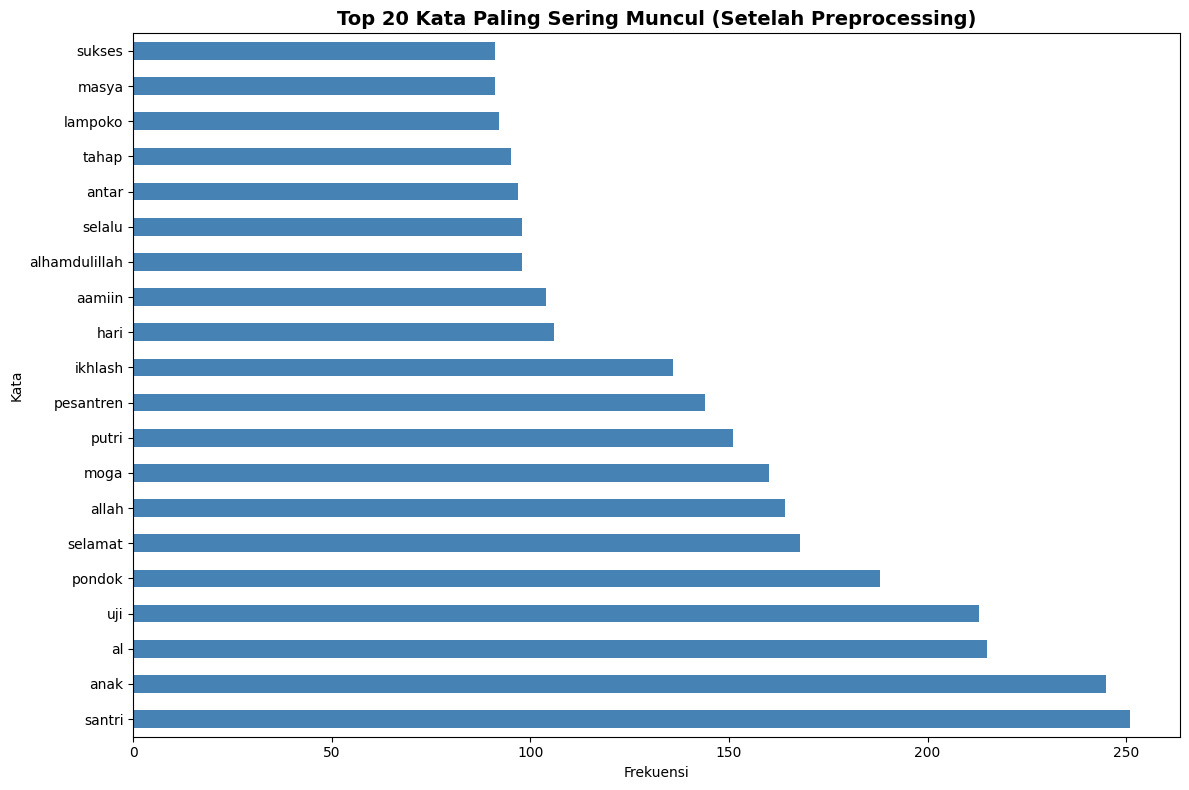

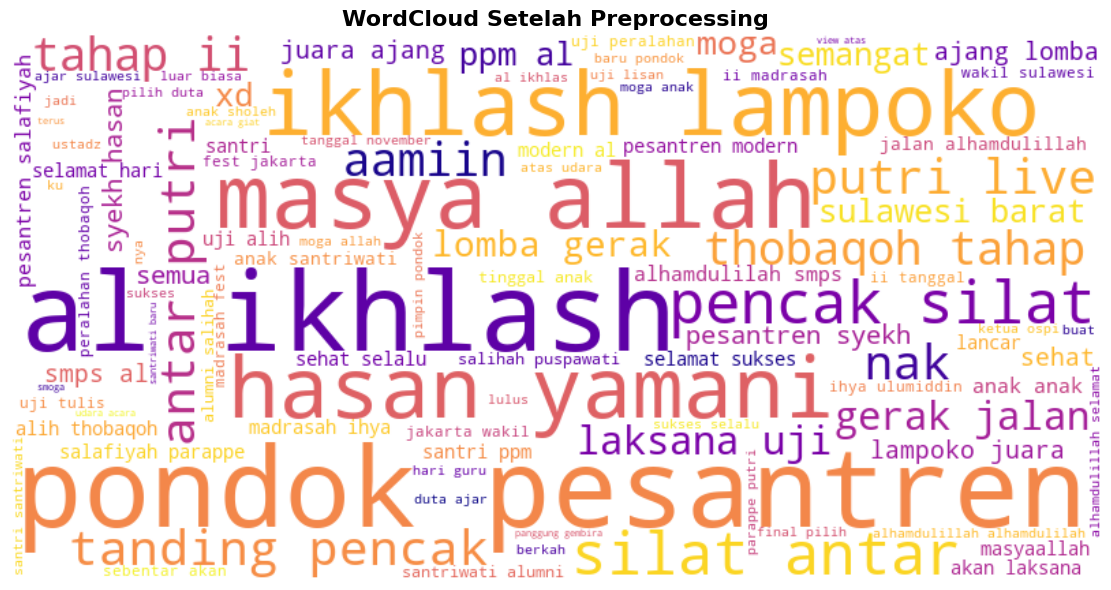

In [58]:

# =====================================================
# 5. ANALISIS FREKUENSI KATA
# =====================================================

def analyze_word_frequency(df, column='text_combined', top_n=20):
    """Analisis frekuensi kata"""
    # Gabungkan semua teks
    all_text = ' '.join(df[column].astype(str))
    
    # Hitung frekuensi kata
    words = all_text.split()
    word_freq = pd.Series(words).value_counts().head(top_n)
    
    # Visualisasi bar chart
    plt.figure(figsize=(12, 8))
    word_freq.plot(kind='barh', color='steelblue')
    plt.title(f'Top {top_n} Kata Paling Sering Muncul (Setelah Preprocessing)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Frekuensi')
    plt.ylabel('Kata')
    plt.tight_layout()
    plt.show()
    
    # Buat wordcloud dari teks yang sudah diproses
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         colormap='plasma',
                         max_words=100).generate(all_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud Setelah Preprocessing', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return word_freq

print("\n=== ANALISIS FREKUENSI KATA ===")
word_frequencies = analyze_word_frequency(df_main)

In [59]:
# =====================================================
# 6. ANALISIS SENTIMEN BERBASIS LEXICON
# =====================================================

def create_lexicon_dict(df_positive, df_negative):
    """Membuat dictionary lexicon"""
    lexicon_dict = {}
    
    # Tambahkan word positif
    for _, row in df_positive.iterrows():
        lexicon_dict[row['word']] = row['weight']
    
    # Tambahkan word negatif
    for _, row in df_negative.iterrows():
        lexicon_dict[row['word']] = row['weight']
    
    return lexicon_dict

def calculate_sentiment_score(text, lexicon_dict):
    """Hitung skor sentimen berdasarkan lexicon"""
    if pd.isna(text) or text == "":
        return 0
    
    words = str(text).split()
    score = 0
    
    for word in words:
        if word in lexicon_dict:
            score += lexicon_dict[word]
    
    return score

def classify_sentiment(score):
    """Klasifikasi sentimen berdasarkan skor"""
    if score > 0:
        return 'Positif'
    elif score < 0:
        return 'Negatif'
    else:
        return 'Netral'

# Buat lexicon dictionary
lexicon_dict = create_lexicon_dict(df_positive, df_negative)
print(f"Total kata dalam lexicon: {len(lexicon_dict)}")

# Hitung skor sentimen
print("Menghitung skor sentimen...")
df_main['sentiment_score'] = df_main['text_combined'].apply(
    lambda x: calculate_sentiment_score(x, lexicon_dict)
)

# Klasifikasi sentimen
df_main['sentimen_lexicon'] = df_main['sentiment_score'].apply(classify_sentiment)

print("Analisis sentimen lexicon selesai!")

Total kata dalam lexicon: 9074
Menghitung skor sentimen...
Analisis sentimen lexicon selesai!


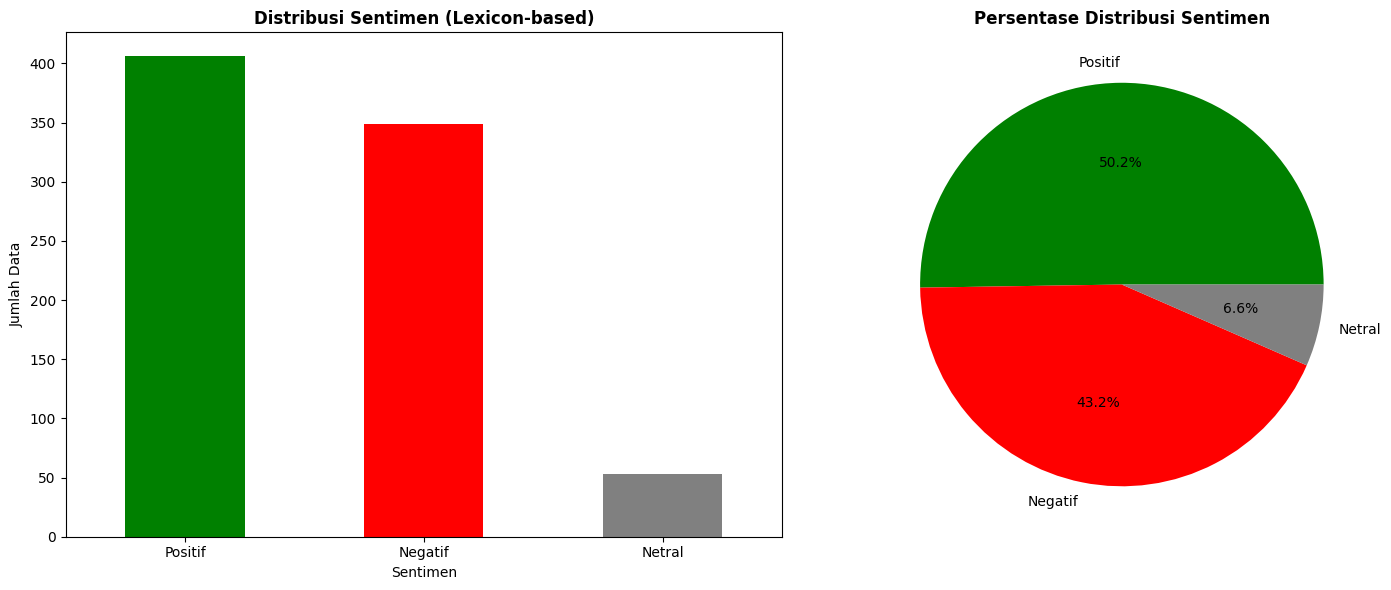

=== STATISTIK SENTIMEN LEXICON ===
Positif: 406 data (50.2%)
Negatif: 349 data (43.2%)
Netral: 53 data (6.6%)


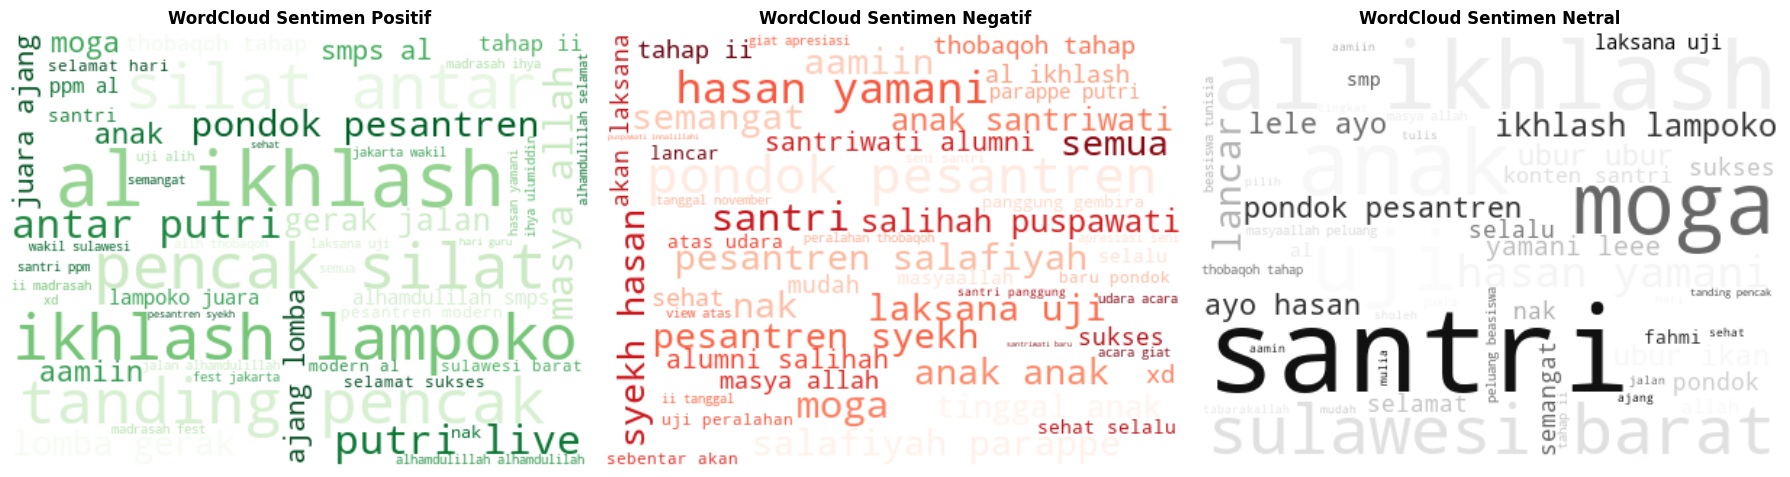

In [60]:
# =====================================================
# 7. VISUALISASI & STATISTIK SENTIMEN LEXICON
# =====================================================

def visualize_sentiment_analysis(df):
    """Visualisasi hasil analisis sentimen"""
    
    # Hitung distribusi sentimen
    sentiment_counts = df['sentimen_lexicon'].value_counts()
    
    # Plot distribusi sentimen
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart
    sentiment_counts.plot(kind='bar', ax=axes[0], color=['green', 'red', 'gray'])
    axes[0].set_title('Distribusi Sentimen (Lexicon-based)', fontweight='bold')
    axes[0].set_xlabel('Sentimen')
    axes[0].set_ylabel('Jumlah Data')
    axes[0].tick_params(axis='x', rotation=0)
    
    # Pie chart
    axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, 
                autopct='%1.1f%%', colors=['green', 'red', 'gray'])
    axes[1].set_title('Persentase Distribusi Sentimen', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistik
    print("=== STATISTIK SENTIMEN LEXICON ===")
    for sentiment, count in sentiment_counts.items():
        percentage = (count / len(df)) * 100
        print(f"{sentiment}: {count} data ({percentage:.1f}%)")
    
    return sentiment_counts

def create_sentiment_wordclouds(df):
    """Buat wordcloud terpisah untuk setiap sentimen"""
    sentiments = ['Positif', 'Negatif', 'Netral']
    colors = ['Greens', 'Reds', 'Greys']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, (sentiment, colormap) in enumerate(zip(sentiments, colors)):
        # Filter data berdasarkan sentimen
        sentiment_data = df[df['sentimen_lexicon'] == sentiment]
        
        if len(sentiment_data) > 0:
            # Gabungkan teks untuk sentimen ini
            text = ' '.join(sentiment_data['text_combined'].astype(str))
            
            if text.strip():  # Pastikan teks tidak kosong
                # Buat wordcloud
                wordcloud = WordCloud(width=400, height=300,
                                     background_color='white',
                                     colormap=colormap,
                                     max_words=50).generate(text)
                
                axes[i].imshow(wordcloud, interpolation='bilinear')
                axes[i].set_title(f'WordCloud Sentimen {sentiment}', fontweight='bold')
            else:
                axes[i].text(0.5, 0.5, f'Tidak ada data\nuntuk sentimen {sentiment}',
                           ha='center', va='center', transform=axes[i].transAxes)
        else:
            axes[i].text(0.5, 0.5, f'Tidak ada data\nuntuk sentimen {sentiment}',
                       ha='center', va='center', transform=axes[i].transAxes)
        
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Jalankan visualisasi sentimen
sentiment_counts = visualize_sentiment_analysis(df_main)
create_sentiment_wordclouds(df_main)

Melakukan Topic Modeling dengan LDA...

=== 10 TOPIK YANG DITEMUKAN ===
Topik 1: tanding, live, pencak, silat, pencak silat
Topik 2: madrasah, uji, sulawesi barat, barat, sulawesi
Topik 3: atas udara, udara, panggung, atas, acara
Topik 4: pondok, pesantren, pondok pesantren, parappe, salafiyah
Topik 5: puspawati, anak santriwati, salihah, salihah puspawati, tinggal
Topik 6: mulia, hari, dunia, akhirat, dunia akhirat
Topik 7: konten, konten santri, ubur, santri, buka porseni
Topik 8: uji, fathul, thobaqoh, laksana uji, laksana
Topik 9: guru, hari guru, kmi, muadalah putra, kelas kmi
Topik 10: al, al ikhlash, ikhlash, lampoko, gerak
Topik 1 -> Umum
Topik 2 -> Umum
Topik 3 -> Sosial
Topik 4 -> Umum
Topik 5 -> Sosial
Topik 6 -> Umum
Topik 7 -> Sosial
Topik 8 -> Umum
Topik 9 -> Kualitas Guru
Topik 10 -> Prestasi


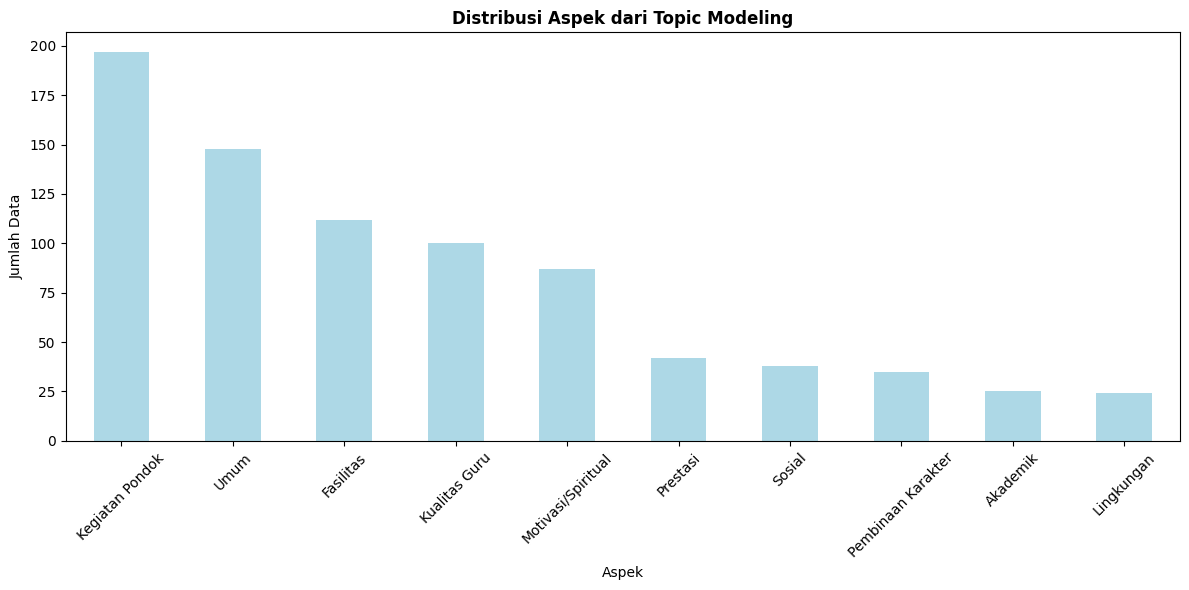

In [61]:
# =====================================================
# 8. TOPIK MODELING DENGAN LDA
# =====================================================

def perform_lda_topic_modeling(df, n_topics=10):
    """Melakukan topic modeling dengan LDA"""
    
    print("Melakukan Topic Modeling dengan LDA...")
    
    # Prepare text data
    documents = df['text_combined'].astype(str).tolist()
    
    # Remove empty documents
    documents = [doc for doc in documents if doc and doc.strip()]
    
    if len(documents) == 0:
        print("Tidak ada dokumen valid untuk topic modeling!")
        return None, None, None
    
    # Vectorization dengan TF-IDF
    vectorizer = TfidfVectorizer(
        max_features=1000,
        min_df=2,
        max_df=0.8,
        ngram_range=(1, 2)
    )
    
    try:
        doc_term_matrix = vectorizer.fit_transform(documents)
        feature_names = vectorizer.get_feature_names_out()
        
        # LDA Model
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            max_iter=100,
            learning_method='online'
        )
        
        lda.fit(doc_term_matrix)
        
        # Get topic words
        def get_top_words(model, feature_names, n_top_words=10):
            topics = []
            for topic_idx, topic in enumerate(model.components_):
                top_words_idx = topic.argsort()[-n_top_words:][::-1]
                top_words = [feature_names[i] for i in top_words_idx]
                topics.append(top_words)
            return topics
        
        topics = get_top_words(lda, feature_names)
        
        # Print topics
        print(f"\n=== {n_topics} TOPIK YANG DITEMUKAN ===")
        for i, topic_words in enumerate(topics):
            print(f"Topik {i+1}: {', '.join(topic_words[:5])}")
        
        return lda, vectorizer, topics
        
    except Exception as e:
        print(f"Error dalam topic modeling: {e}")
        return None, None, None

def map_topics_to_aspects(topics):
    """Pemetaan topik ke aspek manual"""
    
    # Define aspect keywords
    aspect_keywords = {
        'Kualitas Guru': ['guru', 'ajar', 'pengajar', 'ustaz', 'pendidik'],
        'Sosial': ['sosial', 'teman', 'santri', 'bergaul', 'rukun'],
        'Motivasi/Spiritual': ['motivasi', 'spiritual', 'doa', 'ibadah', 'agama'],
        'Kegiatan Pondok': ['kegiatan', 'acara', 'program', 'ekstrakurikuler'],
        'Akademik': ['akademik', 'belajar', 'pelajaran', 'nilai', 'ujian'],
        'Umum': ['umum', 'secara', 'overall', 'keseluruhan'],
        'Fasilitas': ['fasilitas', 'gedung', 'ruang', 'sarana'],
        'Lingkungan': ['lingkungan', 'tempat', 'lokasi', 'suasana'],
        'Pembinaan Karakter': ['karakter', 'akhlak', 'moral', 'etika'],
        'Prestasi': ['prestasi', 'juara', 'lomba', 'achievement']
    }
    
    topic_aspects = []
    
    for i, topic_words in enumerate(topics):
        topic_text = ' '.join(topic_words).lower()
        
        # Hitung skor untuk setiap aspek
        aspect_scores = {}
        for aspect, keywords in aspect_keywords.items():
            score = sum(1 for keyword in keywords if keyword in topic_text)
            aspect_scores[aspect] = score
        
        # Pilih aspek dengan skor tertinggi
        if max(aspect_scores.values()) > 0:
            best_aspect = max(aspect_scores, key=aspect_scores.get)
        else:
            best_aspect = 'Umum'  # Default
        
        topic_aspects.append(best_aspect)
        print(f"Topik {i+1} -> {best_aspect}")
    
    return topic_aspects

def assign_dominant_topic(df, lda_model, vectorizer):
    """Assign topik dominan ke setiap dokumen"""
    
    if lda_model is None or vectorizer is None:
        print("Model LDA tidak valid!")
        return df
    
    documents = df['text_combined'].astype(str).tolist()
    
    # Transform documents
    doc_term_matrix = vectorizer.transform(documents)
    
    # Get topic probabilities
    topic_probs = lda_model.transform(doc_term_matrix)
    
    # Get dominant topic for each document
    dominant_topics = topic_probs.argmax(axis=1)
    
    # Map to aspects (this is a simplified mapping)
    aspect_mapping = {
        0: 'Kualitas Guru',
        1: 'Fasilitas', 
        2: 'Lingkungan',
        3: 'Kegiatan Pondok',
        4: 'Pembinaan Karakter',
        5: 'Prestasi',
        6: 'Akademik',
        7: 'Motivasi/Spiritual',
        8: 'Sosial',
        9: 'Umum'
    }
    
    df['topic_number'] = dominant_topics
    df['aspek_manual'] = [aspect_mapping.get(topic, 'Umum') for topic in dominant_topics]
    
    return df

# Jalankan topic modeling
lda_model, vectorizer, topics = perform_lda_topic_modeling(df_main)

if topics:
    topic_aspects = map_topics_to_aspects(topics)
    df_main = assign_dominant_topic(df_main, lda_model, vectorizer)
    
    # Visualisasi distribusi aspek
    plt.figure(figsize=(12, 6))
    aspect_counts = df_main['aspek_manual'].value_counts()
    aspect_counts.plot(kind='bar', color='lightblue')
    plt.title('Distribusi Aspek dari Topic Modeling', fontweight='bold')
    plt.xlabel('Aspek')
    plt.ylabel('Jumlah Data')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


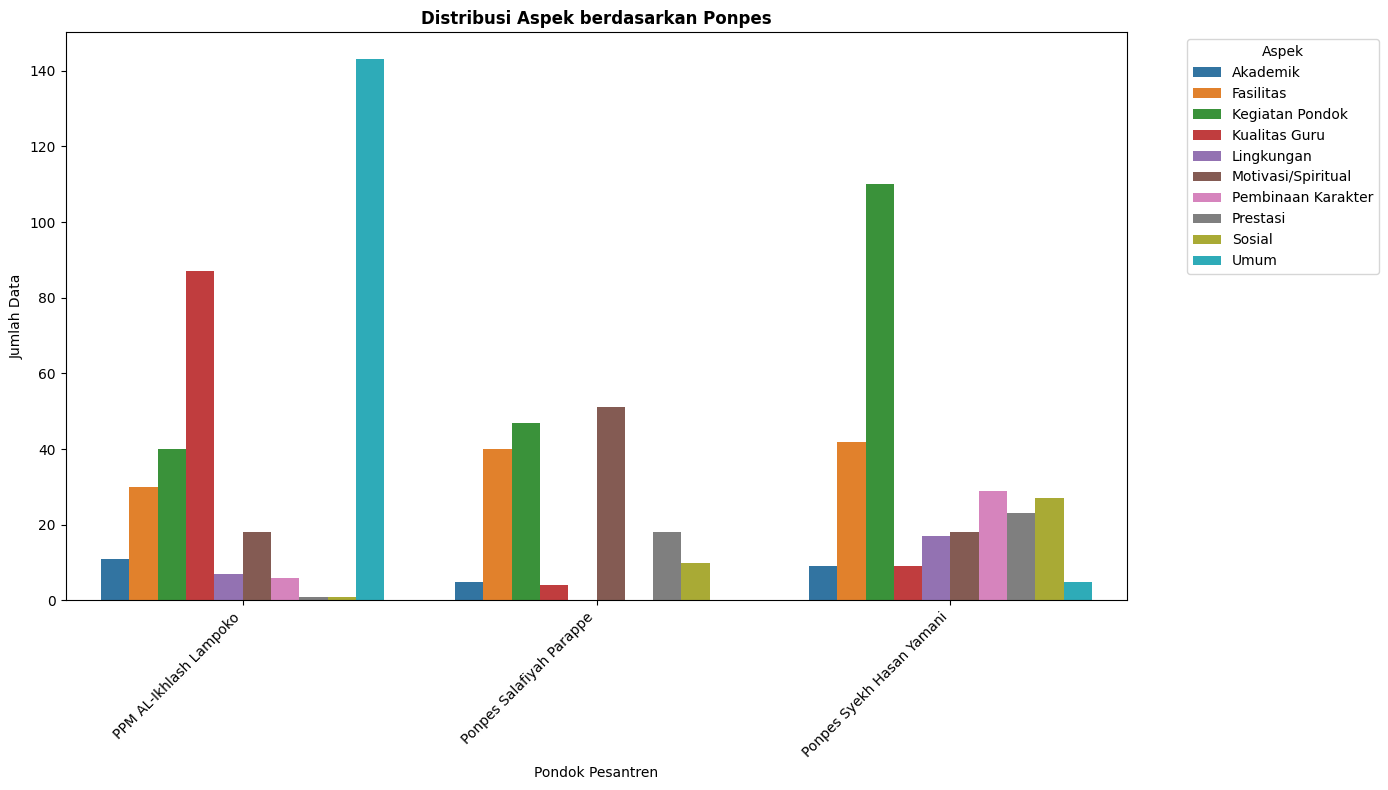

In [62]:
import seaborn as sns

def plot_aspect_distribution_by_ponpes(df):
    """Visualisasi distribusi aspek per pondok pesantren"""
    plt.figure(figsize=(14, 8))
    
    # Hitung frekuensi aspek per ponpes
    aspect_ponpes = df.groupby(['ponpes', 'aspek_manual']).size().reset_index(name='count')
    
    # Plot dengan seaborn barplot (stacked bar lebih sulit, ini side-by-side bar)
    sns.barplot(
        data=aspect_ponpes,
        x='ponpes',
        y='count',
        hue='aspek_manual',
        palette='tab10'
    )
    
    plt.title('Distribusi Aspek berdasarkan Ponpes', fontweight='bold')
    plt.xlabel('Pondok Pesantren')
    plt.ylabel('Jumlah Data')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Aspek', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Pastikan kolom 'ponpes' ada di df_main dan sudah berisi data pondok pesantren
plot_aspect_distribution_by_ponpes(df_main)


In [63]:

# =====================================================
# 9. PENYIMPANAN HASIL ANALISIS AWAL
# =====================================================

def save_initial_results(df, filename='hasil_sentimen_pesantren.csv'):
    """Simpan hasil analisis awal"""
    
    # Pilih kolom yang akan disimpan
    columns_to_save = [
        'no', 'nama', 'kalimat', 'tema_postingan', 'ponpes',
        'text_combined', 'sentiment_score', 'sentimen_lexicon', 'aspek_manual'
    ]
    
    # Filter kolom yang ada
    available_columns = [col for col in columns_to_save if col in df.columns]
    
    df_save = df[available_columns].copy()
    
    # Simpan ke CSV
    df_save.to_csv(filename, index=False, encoding='utf-8')
    print(f"Hasil analisis disimpan ke: {filename}")
    
    # Tampilkan summary
    print(f"\n=== SUMMARY HASIL ANALISIS AWAL ===")
    print(f"Total data: {len(df_save)}")
    print(f"Distribusi Sentimen:")
    print(df_save['sentimen_lexicon'].value_counts())
    print(f"\nDistribusi Aspek:")
    print(df_save['aspek_manual'].value_counts())

# Simpan hasil
save_initial_results(df_main)

print("\n" + "="*50)
print("ANALISIS AWAL SELESAI!")
print("="*50)
print("Lanjutkan dengan menjalankan sel berikutnya untuk")
print("Klasifikasi Sentimen menggunakan RNN...")

Hasil analisis disimpan ke: hasil_sentimen_pesantren.csv

=== SUMMARY HASIL ANALISIS AWAL ===
Total data: 808
Distribusi Sentimen:
sentimen_lexicon
Positif    406
Negatif    349
Netral      53
Name: count, dtype: int64

Distribusi Aspek:
aspek_manual
Kegiatan Pondok       197
Umum                  148
Fasilitas             112
Kualitas Guru         100
Motivasi/Spiritual     87
Prestasi               42
Sosial                 38
Pembinaan Karakter     35
Akademik               25
Lingkungan             24
Name: count, dtype: int64

ANALISIS AWAL SELESAI!
Lanjutkan dengan menjalankan sel berikutnya untuk
Klasifikasi Sentimen menggunakan RNN...


Mempersiapkan data untuk RNN...
Data setelah filtering: 808 sampel
Data training: 646 sampel
Data testing: 162 sampel


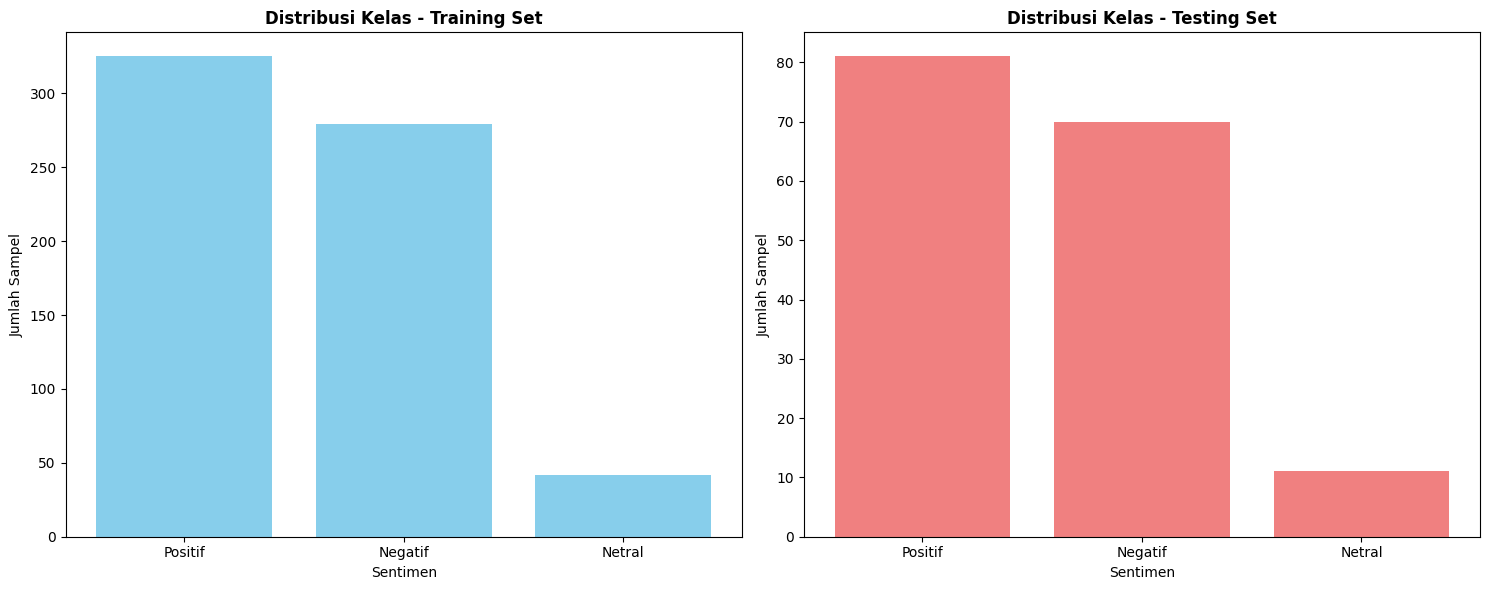


Distribusi Training Set:
Positif: 325 (50.3%)
Negatif: 279 (43.2%)
Netral: 42 (6.5%)

Distribusi Testing Set:
Positif: 81 (50.0%)
Negatif: 70 (43.2%)
Netral: 11 (6.8%)


In [64]:
# =====================================================
# 10a. PERSIAPAN DATA
# =====================================================

def prepare_data_for_rnn(df):
    """Persiapan data untuk training RNN"""
    
    print("Mempersiapkan data untuk RNN...")
    
    # Filter data yang memiliki sentimen (bukan kosong)
    df_filtered = df[df['sentimen_lexicon'].notna()].copy()
    
    # Pastikan ada teks yang valid
    df_filtered = df_filtered[df_filtered['text_combined'].notna()]
    df_filtered = df_filtered[df_filtered['text_combined'].str.strip() != '']
    
    print(f"Data setelah filtering: {len(df_filtered)} sampel")
    
    # Split data menjadi X dan y
    X = df_filtered['text_combined'].values
    y = df_filtered['sentimen_lexicon'].values
    
    return X, y, df_filtered

def split_and_visualize_data(X, y, test_size=0.2, random_state=42):
    """Split data dan visualisasi distribusi"""
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Data training: {len(X_train)} sampel")
    print(f"Data testing: {len(X_test)} sampel")
    
    # Visualisasi distribusi kelas
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training set distribution
    train_counts = pd.Series(y_train).value_counts()
    axes[0].bar(train_counts.index, train_counts.values, color='skyblue')
    axes[0].set_title('Distribusi Kelas - Training Set', fontweight='bold')
    axes[0].set_xlabel('Sentimen')
    axes[0].set_ylabel('Jumlah Sampel')
    
    # Testing set distribution
    test_counts = pd.Series(y_test).value_counts()
    axes[1].bar(test_counts.index, test_counts.values, color='lightcoral')
    axes[1].set_title('Distribusi Kelas - Testing Set', fontweight='bold')
    axes[1].set_xlabel('Sentimen')
    axes[1].set_ylabel('Jumlah Sampel')
    
    plt.tight_layout()
    plt.show()
    
    print("\nDistribusi Training Set:")
    for sentiment, count in train_counts.items():
        percentage = (count / len(y_train)) * 100
        print(f"{sentiment}: {count} ({percentage:.1f}%)")
    
    print("\nDistribusi Testing Set:")
    for sentiment, count in test_counts.items():
        percentage = (count / len(y_test)) * 100
        print(f"{sentiment}: {count} ({percentage:.1f}%)")
    
    return X_train, X_test, y_train, y_test

# Persiapan data
X, y, df_filtered = prepare_data_for_rnn(df_main)
X_train, X_test, y_train, y_test = split_and_visualize_data(X, y)


In [65]:
# =====================================================
# 10b. VEKTORISASI
# =====================================================

def create_sequences(X_train, X_test, y_train, y_test, 
                    max_words=10000, max_len=100):
    """Transformasi teks menjadi sequences untuk RNN"""
    
    print("Melakukan vektorisasi dengan Tokenizer...")
    
    # Initialize tokenizer
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    
    # Fit on training data
    tokenizer.fit_on_texts(X_train)
    
    # Convert to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    # Pad sequences
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Convert to categorical for multi-class
    num_classes = len(label_encoder.classes_)
    y_train_cat = to_categorical(y_train_encoded, num_classes)
    y_test_cat = to_categorical(y_test_encoded, num_classes)
    
    print(f"Vocabulary size: {len(tokenizer.word_index)}")
    print(f"Max sequence length: {max_len}")
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {label_encoder.classes_}")
    
    return (X_train_pad, X_test_pad, y_train_cat, y_test_cat, 
            tokenizer, label_encoder, max_len, max_words)

# Vektorisasi
(X_train_pad, X_test_pad, y_train_cat, y_test_cat, 
 tokenizer, label_encoder, max_len, max_words) = create_sequences(
    X_train, X_test, y_train, y_test
)


Melakukan vektorisasi dengan Tokenizer...
Vocabulary size: 1348
Max sequence length: 100
Number of classes: 3
Classes: ['Negatif' 'Netral' 'Positif']


In [66]:
# =====================================================
# 10c. TRAINING MODEL
# =====================================================

def train_model(model, X_train, y_train, X_test, y_test, 
                model_name="RNN", epochs=20, batch_size=32):
    """Training model dengan callbacks"""
    
    print(f"\nTraining {model_name} Model...")
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.0001,
        verbose=1
    )
    
    # Training
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return history

# Train models
print("Starting model training...")

# Train LSTM
lstm_history = train_model(
    lstm_model, X_train_pad, y_train_cat, X_test_pad, y_test_cat,
    "LSTM", epochs=15
)

# Train Bidirectional LSTM
bilstm_history = train_model(
    bilstm_model, X_train_pad, y_train_cat, X_test_pad, y_test_cat,
    "Bidirectional LSTM", epochs=15
)

# Train GRU
gru_history = train_model(
    gru_model, X_train_pad, y_train_cat, X_test_pad, y_test_cat,
    "GRU", epochs=15
)


Starting model training...

Training LSTM Model...
Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 280ms/step - accuracy: 0.4550 - loss: 1.0189 - val_accuracy: 0.5000 - val_loss: 0.8958 - learning_rate: 0.0010
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.4653 - loss: 0.9027 - val_accuracy: 0.5000 - val_loss: 0.8938 - learning_rate: 0.0010
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.5001 - loss: 0.9063 - val_accuracy: 0.5000 - val_loss: 0.8949 - learning_rate: 0.0010
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.5055 - loss: 0.8966 - val_accuracy: 0.5000 - val_loss: 0.8927 - learning_rate: 0.0010
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.4724 - loss: 0.9079 - val_accuracy: 0.5000 - val_loss: 0.8940 - learning_rate: 0.0010
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.5297 - loss: 0.8830 - val_accuracy: 0.5000 - val_loss: 0.8927 - learning_rate: 0.0010
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━


=== EVALUASI LSTM MODEL ===
Accuracy: 0.5000

Classification Report:


d:\PENDIDIKAN S2\S4\SENTIMEN ABSA\absa\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PENDIDIKAN S2\S4\SENTIMEN ABSA\absa\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PENDIDIKAN S2\S4\SENTIMEN ABSA\absa\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        70
      Netral       0.00      0.00      0.00        11
     Positif       0.50      1.00      0.67        81

    accuracy                           0.50       162
   macro avg       0.17      0.33      0.22       162
weighted avg       0.25      0.50      0.33       162



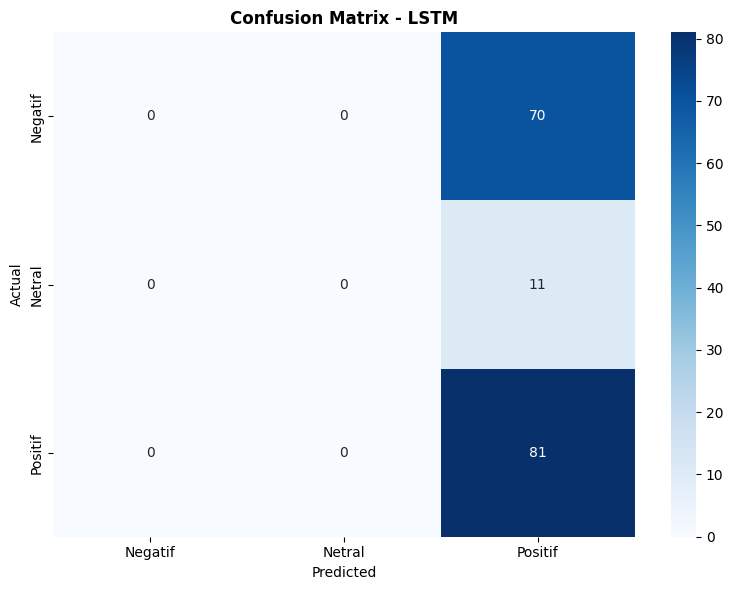


=== EVALUASI BIDIRECTIONAL LSTM MODEL ===
Accuracy: 0.8395

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.84      0.90      0.87        70
      Netral       0.00      0.00      0.00        11
     Positif       0.84      0.90      0.87        81

    accuracy                           0.84       162
   macro avg       0.56      0.60      0.58       162
weighted avg       0.78      0.84      0.81       162



d:\PENDIDIKAN S2\S4\SENTIMEN ABSA\absa\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PENDIDIKAN S2\S4\SENTIMEN ABSA\absa\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PENDIDIKAN S2\S4\SENTIMEN ABSA\absa\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

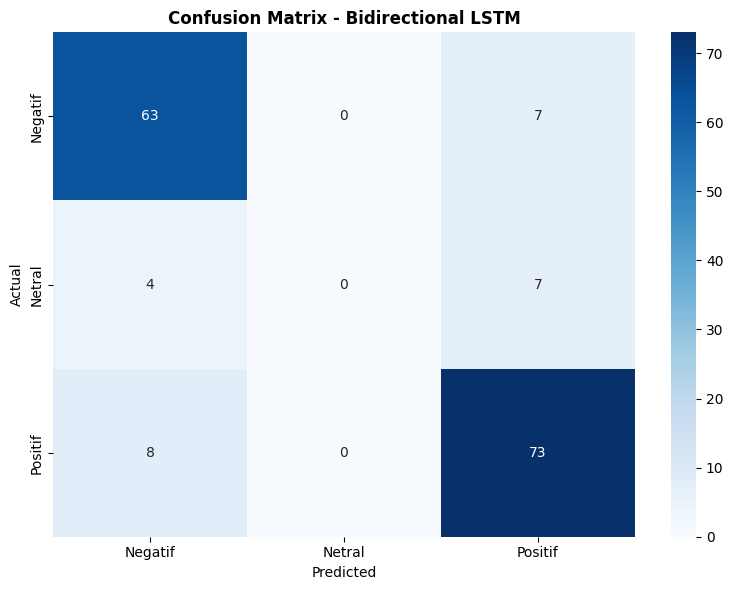


=== EVALUASI GRU MODEL ===
Accuracy: 0.5000

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.00      0.00      0.00        70
      Netral       0.00      0.00      0.00        11
     Positif       0.50      1.00      0.67        81

    accuracy                           0.50       162
   macro avg       0.17      0.33      0.22       162
weighted avg       0.25      0.50      0.33       162



d:\PENDIDIKAN S2\S4\SENTIMEN ABSA\absa\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PENDIDIKAN S2\S4\SENTIMEN ABSA\absa\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PENDIDIKAN S2\S4\SENTIMEN ABSA\absa\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

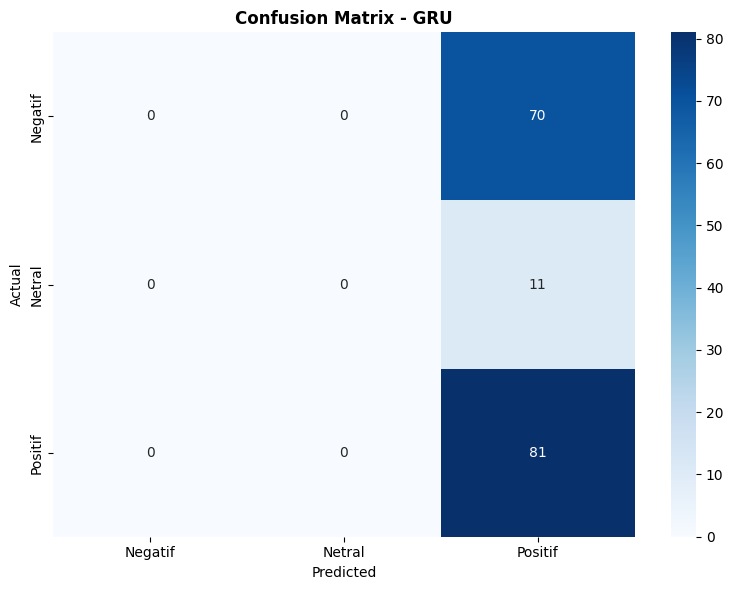

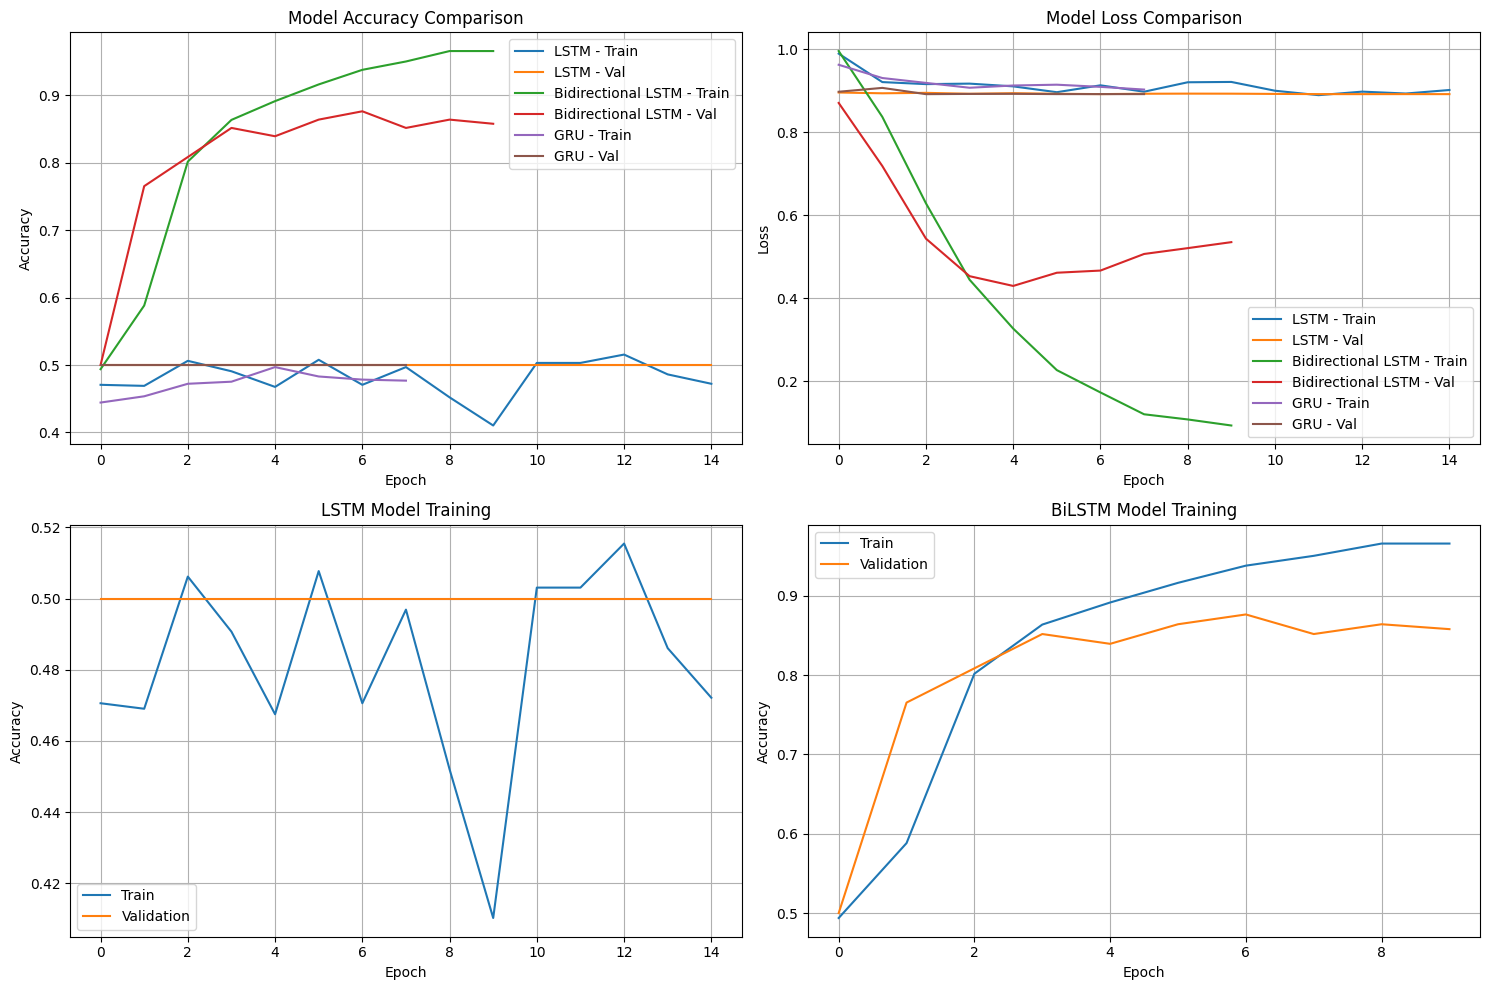

In [67]:
# =====================================================
# 10d. EVALUASI MODEL
# =====================================================

def evaluate_model(model, X_test, y_test, y_test_original, 
                  label_encoder, model_name="RNN"):
    """Evaluasi komprehensif model"""
    
    print(f"\n=== EVALUASI {model_name.upper()} MODEL ===")
    
    # Prediksi
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred_encoded = np.argmax(y_pred_prob, axis=1)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    
    # Accuracy
    accuracy = accuracy_score(y_test_original, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_original, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_original, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}', fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    return accuracy, y_pred

def plot_training_history(histories, model_names):
    """Plot training history untuk semua model"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    for history, name in zip(histories, model_names):
        axes[0, 0].plot(history.history['accuracy'], label=f'{name} - Train')
        axes[0, 0].plot(history.history['val_accuracy'], label=f'{name} - Val')
    axes[0, 0].set_title('Model Accuracy Comparison')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    for history, name in zip(histories, model_names):
        axes[0, 1].plot(history.history['loss'], label=f'{name} - Train')
        axes[0, 1].plot(history.history['val_loss'], label=f'{name} - Val')
    axes[0, 1].set_title('Model Loss Comparison')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Individual LSTM history
    axes[1, 0].plot(lstm_history.history['accuracy'], label='Train')
    axes[1, 0].plot(lstm_history.history['val_accuracy'], label='Validation')
    axes[1, 0].set_title('LSTM Model Training')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Individual BiLSTM history
    axes[1, 1].plot(bilstm_history.history['accuracy'], label='Train')
    axes[1, 1].plot(bilstm_history.history['val_accuracy'], label='Validation')
    axes[1, 1].set_title('BiLSTM Model Training')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Evaluasi semua model
models = [lstm_model, bilstm_model, gru_model]
model_names = ["LSTM", "Bidirectional LSTM", "GRU"]
histories = [lstm_history, bilstm_history, gru_history]

results = {}
predictions = {}

for model, name in zip(models, model_names):
    accuracy, y_pred = evaluate_model(
        model, X_test_pad, y_test_cat, y_test, label_encoder, name
    )
    results[name] = accuracy
    predictions[name] = y_pred

# Plot training histories
plot_training_history(histories, model_names)



=== PERBANDINGAN HASIL MODEL ===

Ranking Model berdasarkan Accuracy:
             Model  Accuracy
Bidirectional LSTM  0.839506
              LSTM  0.500000
               GRU  0.500000


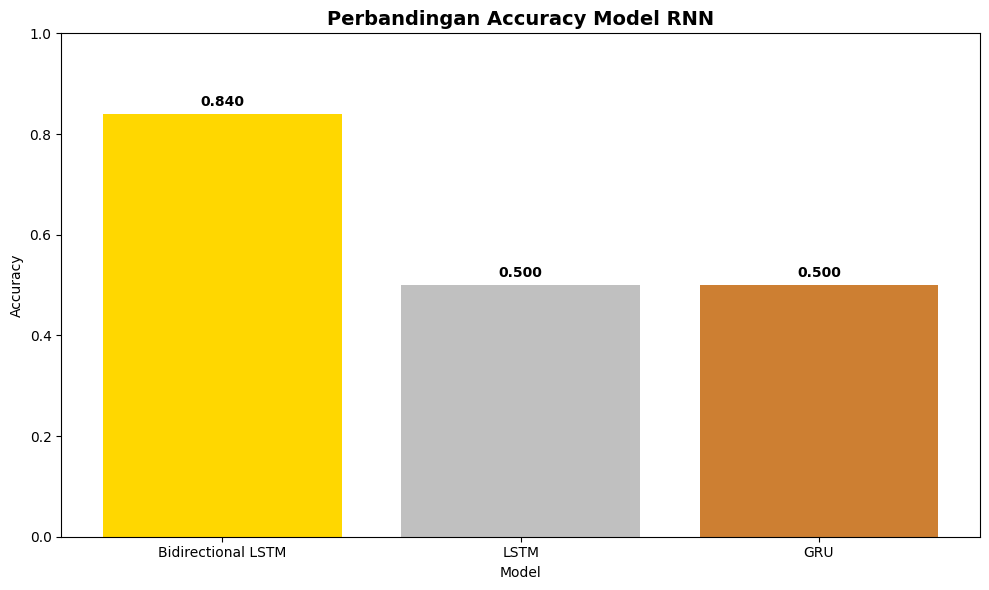


🏆 MODEL TERBAIK: Bidirectional LSTM
🎯 ACCURACY TERBAIK: 0.8395


In [68]:
# =====================================================
# PERBANDINGAN HASIL MODEL
# =====================================================

def compare_model_results(results, predictions, y_test):
    """Perbandingan hasil semua model"""
    
    print("\n=== PERBANDINGAN HASIL MODEL ===")
    
    # Tabel perbandingan accuracy
    comparison_df = pd.DataFrame([
        {"Model": name, "Accuracy": acc} 
        for name, acc in results.items()
    ]).sort_values('Accuracy', ascending=False)
    
    print("\nRanking Model berdasarkan Accuracy:")
    print(comparison_df.to_string(index=False))
    
    # Visualisasi perbandingan
    plt.figure(figsize=(10, 6))
    bars = plt.bar(comparison_df['Model'], comparison_df['Accuracy'], 
                   color=['gold', 'silver', '#CD7F32'])
    plt.title('Perbandingan Accuracy Model RNN', fontweight='bold', fontsize=14)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, acc in zip(bars, comparison_df['Accuracy']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_accuracy = comparison_df.iloc[0]['Accuracy']
    
    print(f"\n🏆 MODEL TERBAIK: {best_model_name}")
    print(f"🎯 ACCURACY TERBAIK: {best_accuracy:.4f}")
    
    return best_model_name, best_accuracy

# Bandingkan hasil
best_model_name, best_accuracy = compare_model_results(results, predictions, y_test)


In [69]:
# =====================================================
# ANALISIS DETAIL HASIL TERBAIK
# =====================================================

def detailed_analysis_best_model(best_model_name, predictions, y_test, df_filtered):
    """Analisis detail untuk model terbaik"""
    
    print(f"\n=== ANALISIS DETAIL {best_model_name} ===")
    
    best_predictions = predictions[best_model_name]
    
    # Buat dataframe hasil
    results_df = pd.DataFrame({
        'actual': y_test,
        'predicted': best_predictions,
        'text': X_test,
        'correct': y_test == best_predictions
    })
    
    # Statistik prediksi benar/salah
    correct_preds = results_df['correct'].sum()
    total_preds = len(results_df)
    accuracy = correct_preds / total_preds
    
    print(f"Prediksi Benar: {correct_preds}/{total_preds} ({accuracy:.1%})")
    print(f"Prediksi Salah: {total_preds - correct_preds}/{total_preds} ({(1-accuracy):.1%})")
    
    # Contoh prediksi yang benar
    print(f"\n=== CONTOH PREDIKSI BENAR ===")
    correct_samples = results_df[results_df['correct'] == True].head(3)
    for i, row in correct_samples.iterrows():
        print(f"\nTeks: {row['text'][:100]}...")
        print(f"Actual: {row['actual']} | Predicted: {row['predicted']} ✅")
    
    # Contoh prediksi yang salah
    print(f"\n=== CONTOH PREDIKSI SALAH ===")
    wrong_samples = results_df[results_df['correct'] == False].head(3)
    if len(wrong_samples) > 0:
        for i, row in wrong_samples.iterrows():
            print(f"\nTeks: {row['text'][:100]}...")
            print(f"Actual: {row['actual']} | Predicted: {row['predicted']} ❌")
    else:
        print("Tidak ada prediksi yang salah! 🎉")
    
    return results_df

# Analisis detail
results_df = detailed_analysis_best_model(best_model_name, predictions, y_test, df_filtered)



=== ANALISIS DETAIL Bidirectional LSTM ===
Prediksi Benar: 136/162 (84.0%)
Prediksi Salah: 26/162 (16.0%)

=== CONTOH PREDIKSI BENAR ===

Teks: masya allah suasana upacara agustus...
Actual: Positif | Predicted: Positif ✅

Teks: sukses selalu anak syg lomba gerak jalan tingkat kabupaten...
Actual: Positif | Predicted: Positif ✅

Teks: moga seluruh santri beri mudah uji sebentar akan laksana uji peralahan thobaqoh tahap ii tanggal nov...
Actual: Negatif | Predicted: Negatif ✅

=== CONTOH PREDIKSI SALAH ===

Teks: sehat slalu annangguru murobbi gurunda tuan guru ust abdul shomad murobbi kiyai amin said al mahdal...
Actual: Negatif | Predicted: Positif ❌

Teks: moga lancar ujianx naksalam aamin liput vidio uji lisan putra...
Actual: Netral | Predicted: Negatif ❌

Teks: iya nak semngat terus kalah menang tdk masalah penting alam nya tanding pencak silat antar putri liv...
Actual: Negatif | Predicted: Positif ❌


In [70]:
# =====================================================
# 11. EVALUASI MANUAL & PENYEMPURNAAN
# =====================================================

def manual_evaluation_suggestions():
    """Saran untuk evaluasi manual dan penyempurnaan"""
    
    print("\n" + "="*60)
    print("11. EVALUASI MANUAL & SARAN PENYEMPURNAAN")
    print("="*60)
    
    suggestions = """
    📋 CHECKLIST EVALUASI MANUAL:
    
    1. ✅ VALIDASI SAMPEL DATA:
       - Periksa 20-50 sampel prediksi secara manual
       - Bandingkan dengan label sebenarnya
       - Identifikasi pola kesalahan
    
    2. 🔍 ANALISIS KESALAHAN:
       - Kategori teks yang sering salah diprediksi
       - Apakah ada bias terhadap kelas tertentu?
       - Pengaruh panjang teks terhadap akurasi
    
    3. 🛠️ PENYEMPURNAAN PREPROCESSING:
       - Tambah normalisasi kata slang
       - Perbaiki stemming untuk kata khusus pesantren
       - Pertimbangkan n-gram features
    
    4. 📊 PENYEMPURNAAN MODEL:
       - Coba arsitektur yang berbeda (CNN-LSTM, Transformer)
       - Hyperparameter tuning lebih detail
       - Ensemble methods
    
    5. 📈 PENYEMPURNAAN DATA:
       - Tambah data training jika memungkinkan
       - Balance class distribution
       - Data augmentation untuk kelas minoritas
    
    6. 🎯 TOPIC MODELING:
       - Validasi mapping topik ke aspek
       - Pertimbangkan manual labeling sebagian data
       - Coba algoritma topic modeling lain (BERTopic, etc.)
    """
    
    print(suggestions)
    
    # Summary metrics untuk evaluasi
    print("\n📊 SUMMARY METRICS UNTUK EVALUASI:")
    print(f"• Best Model: {best_model_name}")
    print(f"• Best Accuracy: {best_accuracy:.4f}")
    print(f"• Total Data: {len(df_main)}")
    print(f"• Training Samples: {len(X_train)}")
    print(f"• Testing Samples: {len(X_test)}")
    
    return suggestions

# Jalankan evaluasi manual
manual_suggestions = manual_evaluation_suggestions()



11. EVALUASI MANUAL & SARAN PENYEMPURNAAN

    📋 CHECKLIST EVALUASI MANUAL:

    1. ✅ VALIDASI SAMPEL DATA:
       - Periksa 20-50 sampel prediksi secara manual
       - Bandingkan dengan label sebenarnya
       - Identifikasi pola kesalahan

    2. 🔍 ANALISIS KESALAHAN:
       - Kategori teks yang sering salah diprediksi
       - Apakah ada bias terhadap kelas tertentu?
       - Pengaruh panjang teks terhadap akurasi

    3. 🛠️ PENYEMPURNAAN PREPROCESSING:
       - Tambah normalisasi kata slang
       - Perbaiki stemming untuk kata khusus pesantren
       - Pertimbangkan n-gram features

    4. 📊 PENYEMPURNAAN MODEL:
       - Coba arsitektur yang berbeda (CNN-LSTM, Transformer)
       - Hyperparameter tuning lebih detail
       - Ensemble methods

    5. 📈 PENYEMPURNAAN DATA:
       - Tambah data training jika memungkinkan
       - Balance class distribution
       - Data augmentation untuk kelas minoritas

    6. 🎯 TOPIC MODELING:
       - Validasi mapping topik ke aspek
       - Pe

In [72]:
# =====================================================
# SAVE FINAL RESULTS
# =====================================================

def save_final_results():
    """Simpan hasil akhir analisis"""
    
    # Simpan model terbaik
    if best_model_name == "LSTM":
        best_model = lstm_model
    elif best_model_name == "Bidirectional LSTM":
        best_model = bilstm_model
    else:
        best_model = gru_model
    
    # Simpan model
    best_model.save('model/best_sentiment_model.h5')
    print(f"✅ Model terbaik ({best_model_name}) disimpan sebagai 'best_sentiment_model.h5'")
    
    # Simpan tokenizer
    import pickle
    with open('/pkltokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
    
    with open('pkl/label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    
    print("✅ Tokenizer dan Label Encoder disimpan")
    
    # Simpan hasil prediksi
    final_results = results_df.copy()
    final_results.to_csv('final/final_predictions.csv', index=False)
    print("✅ Hasil prediksi disimpan sebagai 'final_predictions.csv'")
    
    # Simpan summary
    summary = {
        'best_model': best_model_name,
        'best_accuracy': best_accuracy,
        'total_data': len(df_main),
        'training_samples': len(X_train),
        'testing_samples': len(X_test),
        'model_comparison': results
    }
    
    with open('pkl/analysis_summary.pkl', 'wb') as f:
        pickle.dump(summary, f)
    
    print("✅ Summary analisis disimpan sebagai 'analysis_summary.pkl'")

# Simpan hasil akhir
save_final_results()

print("\n" + "🎉"*20)
print("ANALISIS SENTIMEN DAN TOPIC MODELING SELESAI!")
print("🎉"*20)
print(f"\n🏆 HASIL TERBAIK:")
print(f"   Model: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}")
print(f"\n📁 FILE YANG DIHASILKAN:")
print("   • hasil_sentimen_pesantren.csv")
print("   • best_sentiment_model.h5")
print("   • tokenizer.pkl")
print("   • label_encoder.pkl")
print("   • final_predictions.csv")
print("   • analysis_summary.pkl")

✅ Model terbaik (Bidirectional LSTM) disimpan sebagai 'best_sentiment_model.h5'
✅ Tokenizer dan Label Encoder disimpan
✅ Hasil prediksi disimpan sebagai 'final_predictions.csv'
✅ Summary analisis disimpan sebagai 'analysis_summary.pkl'

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
ANALISIS SENTIMEN DAN TOPIC MODELING SELESAI!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

🏆 HASIL TERBAIK:
   Model: Bidirectional LSTM
   Accuracy: 0.8395

📁 FILE YANG DIHASILKAN:
   • hasil_sentimen_pesantren.csv
   • best_sentiment_model.h5
   • tokenizer.pkl
   • label_encoder.pkl
   • final_predictions.csv
   • analysis_summary.pkl
